In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Classification

## Data Preparation
- prepare your data for the classification task
- decide a categorical variable to predict (`outcome_type` is the most natural for this dataset)
    - the target variable should transformed to numerical (0, 1, 2 ...)
- remove all the variable that are not necessary or "leak" information about your target.
- divide the dataset in train/test
- for each classifier perform the correct preprocessing.

In [3]:
dogs=pd.read_csv('dogs4_noPH.csv')

In [4]:
dogs.head()

,outcome_subtype,outcome_type,sex_upon_outcome,breed,color,intake_condition,intake_type,size,good_with_children,good_with_other_dogs,...,barking,age,length_of_stay,log_age,log_lenghtOfStay,breed_avg_life_expectancy,breed_avg_height,KMeans_Label,Hlabel_c,Hlabel_w
0,Foster,Adoption,Intact Male,Greyhound Mix,Tan,Normal,Stray,large,2.625100,3.615374,...,1.974363,63,31,4.143135,3.433987,4198.0,29.00,6,4,6
1,Foster,Adoption,Spayed Female,Boxer Mix,Brown,Normal,Stray,large,5.835203,2.925542,...,2.737943,70,33,4.248495,3.496508,4015.0,24.00,2,1,5
2,Partner,Transfer,Intact Male,Chihuahua Shorthair Mix,Red,Normal,Stray,teacup,2.544920,4.314612,...,5.015286,2942,6,7.986845,1.791759,5475.0,6.50,1,1,2
3,Partner,Transfer,Neutered Male,Pomeranian Mix,White,Normal,Stray,teacup,2.835409,2.936067,...,3.420557,3294,7,8.099858,1.945910,5110.0,6.50,6,1,6
4,Partner,Transfer,Spayed Female,Shih Tzu Mix,White,Normal,Stray,small,4.391545,4.955892,...,2.754888,375,5,5.926926,1.609438,5110.0,9.75,5,2,4


##### Comment
Some of the outcomes only have a few data points. To improve the performance of machine learning algorithms, it is better to group them into bigger categories when possible.
I have grouped outcomes 'Died', 'Euthanasia', 'Missing' into 'Dead', as they all represent a negative outcome for the dog.

In [5]:
t_classes={
    'Adoption':'Adoption',
    'Died':'Dead',
    'Euthanasia':'Dead',
    'Missing':'Dead',
    'Transfer':'Transfer',
    'Return to Owner':'Return to Owner'
}
y=dogs['outcome_type'].map(t_classes).values

In [6]:
temp=dogs[['good_with_children', 'good_with_other_dogs','shedding', 'grooming', 'drooling', 
        'coat_length','good_with_strangers', 'playfulness', 'protectiveness', 'trainability',
       'energy', 'barking','log_age','log_lenghtOfStay','breed_avg_life_expectancy']]

In [7]:
sex=pd.get_dummies(dogs['sex_upon_outcome']).astype(float)
size=pd.get_dummies(dogs['size']).astype(float)
intake=pd.get_dummies(dogs['intake_type']).astype(float)

In [8]:
temp=pd.concat([temp, sex, size,intake], axis=1)
X=temp.values

In [9]:
#selecting 70% of data for training
X_train_o, X_test, y_train_o, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y
                                                   )

In [10]:
#set aside 30% of train dataset to form validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_o, y_train_o, 
                                                    test_size=0.3, 
                                                    stratify=y_train_o
                                                   )

## Dummy
It's always a good idea to understand how well a naive model performs. You can use the DummyClassifier for that. If your next model do worse than naive... well, you may have a problem!

In [11]:
from sklearn.dummy import DummyClassifier

In [12]:
clf = DummyClassifier()

In [13]:
clf.fit(X_train_o,y_train_o)

DummyClassifier()

In [14]:
y_pred=clf.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.0000    0.0000    0.0000       267
           Dead     0.0000    0.0000    0.0000       145
Return to Owner     0.0000    0.0000    0.0000        46
       Transfer     0.6377    1.0000    0.7787       806

       accuracy                         0.6377      1264
      macro avg     0.1594    0.2500    0.1947      1264
   weighted avg     0.4066    0.6377    0.4966      1264



## Decision Tree
- find the best parameters
- evaluate the performance of your model (with the correct metrics and plots)
- plot the decision tree and try to interpret it. Which are the most important features?

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text

In [17]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, None]

accuracy_list_val = list()
accuracy_list_train = list()

for max_depth in max_depth_list:
    tree = DecisionTreeClassifier(max_depth=max_depth,min_samples_split=30,min_samples_leaf=10)
    tree.fit(X_train, y_train)
    y_pred_val = tree.predict(X_val)
    y_pred_train = tree.predict(X_train)
    
    accuracy_list_val.append(accuracy_score(y_val, y_pred_val))
    accuracy_list_train.append(accuracy_score(y_train, y_pred_train))

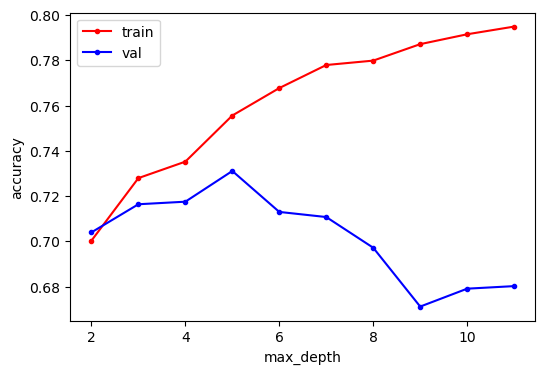

In [18]:
plt.figure(figsize=(6, 4))
max_depth_list_plot = np.arange(2, 12)
plt.plot(max_depth_list_plot, accuracy_list_train, label='train', marker='.', c='r')
plt.plot(max_depth_list_plot, accuracy_list_val, label='val', marker='.', c='b')

plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend()
plt.show()

##### Comment
Comparing the accuracy on training and validation set, the best depth parameter is 5. For depths >5, accuracy increases on the train set, but decreases on the validation set, meaning the model is overfitting.

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [20]:
param_grid = {
    'max_depth': [2,3,4,5,6,7,8,9,10,None],
    'criterion': ['gini', 'entropy'], 
    'min_samples_split': [5, 10, 25, 50], 
    'min_samples_leaf': [3, 5, 10, 20, 30] 
}

tree = DecisionTreeClassifier()

gs = GridSearchCV(tree, param_grid=param_grid, cv=10, refit=True, scoring='accuracy')

gs.fit(X_train_o, y_train_o)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'min_samples_leaf': [3, 5, 10, 20, 30],
                         'min_samples_split': [5, 10, 25, 50]},
             scoring='accuracy')

In [21]:
best_tree=gs.best_params_
best_tree

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 30,
 'min_samples_split': 5}

##### Comment
Using a grid search to look at some of the other parameters in the tree to choose the ones giving the best performance.

In [58]:
tree = DecisionTreeClassifier(max_depth=5,criterion='gini', min_samples_split=5, min_samples_leaf=30)
tree.fit(X_train_o, y_train_o)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=30, min_samples_split=5)

In [59]:
y_pred=tree.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.7455    0.6255    0.6802       267
           Dead     0.8421    0.1103    0.1951       145
Return to Owner     0.4000    0.1739    0.2424        46
       Transfer     0.7483    0.9293    0.8290       806

       accuracy                         0.7437      1264
      macro avg     0.6840    0.4598    0.4867      1264
   weighted avg     0.7458    0.7437    0.7035      1264



##### Comment
The accuracy is better compared to the dummy classifier and, to some extent, all outcomes are predicted.

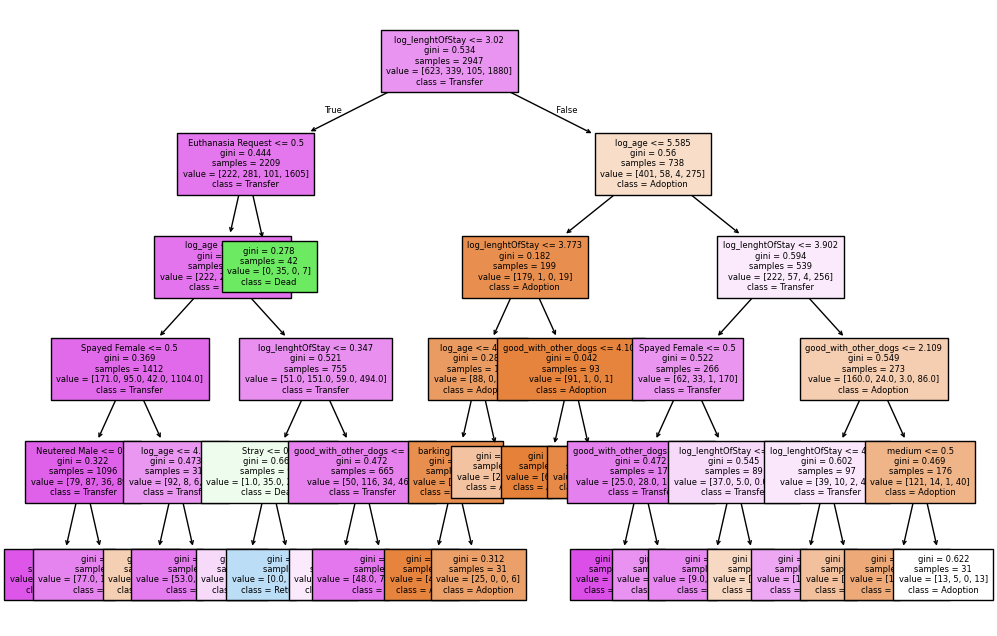

In [61]:
columns=temp.columns
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=columns, class_names=tree.classes_, 
          filled=True,
          fontsize=6
         )
plt.show()

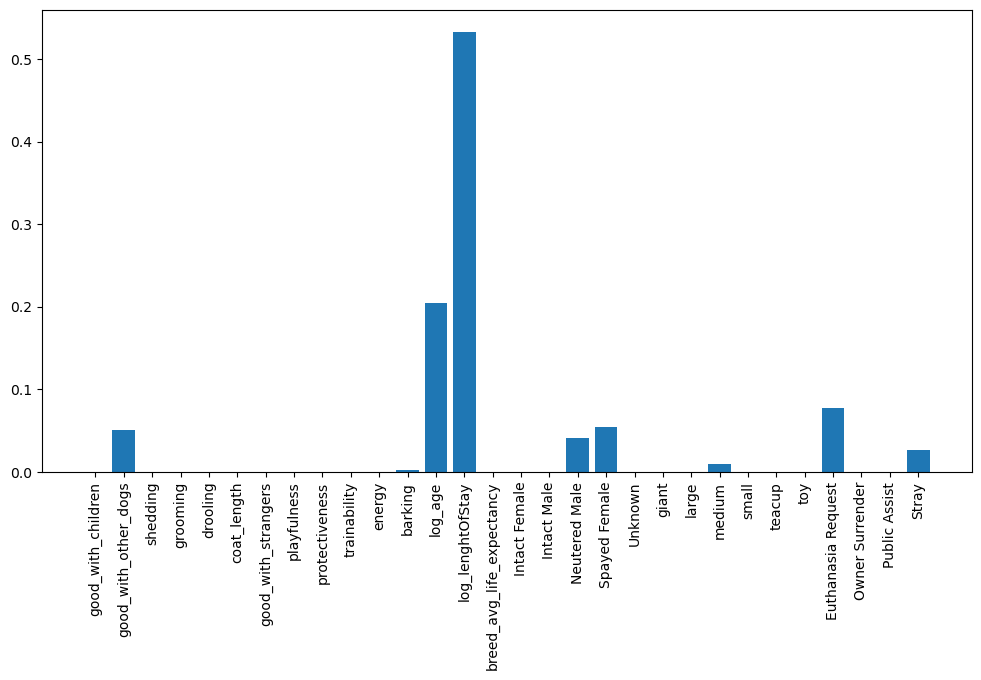

In [62]:
plt.figure(figsize=(12,6))
plt.bar(columns, tree.feature_importances_)
plt.xticks(rotation=90)
plt.show()

##### Comment
The most important features are age and length of stay. Dog's characteristics and size do not have a big influence in the decision tree.

## KNN
- find the best k parameter and the best distance. show how performance varies depending on k
- evaluate the performance of your best model using the correct plots

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [28]:
standard=StandardScaler()
X_tr=standard.fit_transform(X_train)
X_v=standard.transform(X_val)
X_ts=standard.transform(X_test)

In [29]:
knn=KNeighborsClassifier(n_neighbors=8, weights='distance')

In [30]:
knn.fit(X_tr,y_train)

KNeighborsClassifier(n_neighbors=8, weights='distance')

In [31]:
y_v=knn.predict(X_v)

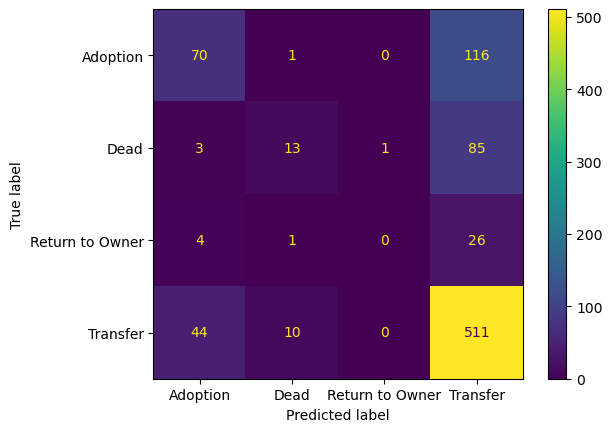

In [32]:
cm=confusion_matrix(y_val,y_v)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot()

In [33]:
print(classification_report(y_val, y_v, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.5785    0.3743    0.4545       187
           Dead     0.5200    0.1275    0.2047       102
Return to Owner     0.0000    0.0000    0.0000        31
       Transfer     0.6924    0.9044    0.7843       565

       accuracy                         0.6712       885
      macro avg     0.4477    0.3516    0.3609       885
   weighted avg     0.6242    0.6712    0.6204       885



##### Comment
A first try with KNN gives a worse performance compared to the decision tree. The return to owner category is not predicted. Trying different parameters in order to find the best model.
Checking for both 'distance' and 'uniform' weights with different neighbouring points values.

In [34]:
X_tr_o=standard.fit_transform(X_train_o)

In [35]:
k_list = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]

scores_listD = list()
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X_tr_o, y_train_o, cv=10, scoring='accuracy')
    scores_listD.append(scores)
    
scores_listD = np.array(scores_listD)

In [36]:
scores_listU = list()
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    scores = cross_val_score(knn, X_tr_o, y_train_o, cv=10, scoring='accuracy')
    scores_listU.append(scores)
    
scores_listU = np.array(scores_listU)

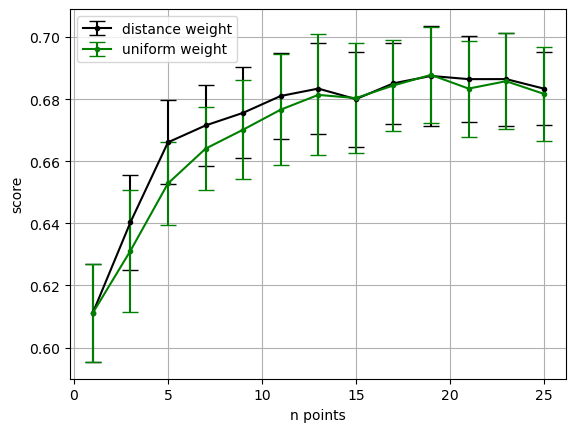

In [37]:
plt.errorbar(k_list, np.mean(scores_listD, axis=1), yerr=np.std(scores_listD, axis=1), 
             marker='.', capsize=6, color='k', label='distance weight')
plt.errorbar(k_list, np.mean(scores_listU, axis=1), yerr=np.std(scores_listU, axis=1),
             marker='.', capsize=6, color='g', label='uniform weight')
plt.legend()

plt.grid()
plt.xlabel('n points')
plt.ylabel('score')
plt.show()

##### Comment
choosing 'distance' weight and 13 neighbours which gives a high score with the lowest standard deviation.

In [63]:
knn=KNeighborsClassifier(n_neighbors=13, weights='distance')

In [64]:
knn.fit(X_tr_o,y_train_o)

KNeighborsClassifier(n_neighbors=13, weights='distance')

In [65]:
y_pred=knn.predict(X_ts)

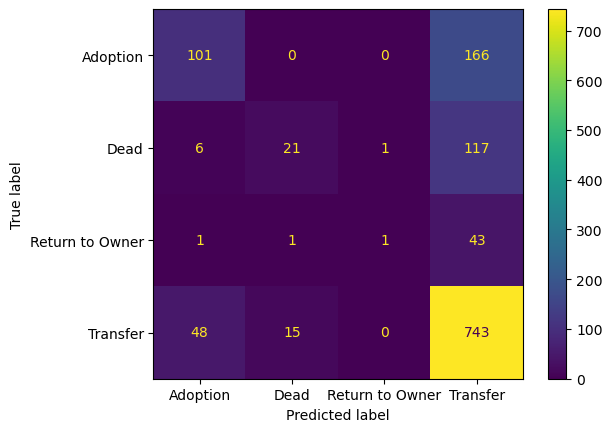

In [66]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot()

In [67]:
print(classification_report(y_test, y_pred, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.6474    0.3783    0.4775       267
           Dead     0.5676    0.1448    0.2308       145
Return to Owner     0.5000    0.0217    0.0417        46
       Transfer     0.6950    0.9218    0.7925       806

       accuracy                         0.6851      1264
      macro avg     0.6025    0.3667    0.3856      1264
   weighted avg     0.6633    0.6851    0.6342      1264



##### Comment
No improvement in the performance of KNN. Infact, the accuracy score on the test set is lower than it was on the validation set with a random choice of paramenters. The return to owner class is not predicted.

## Random Forest
- find the best parameters
- evaluate model performance
- (optional) find the most important features (`clf.feature_importances_`)

In [43]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

##### Comment
Initialising a random forest classifier using the charateristics found for the best tree classifier.

In [68]:
rf=RandomForestClassifier(n_estimators=100, max_depth=5,
                          criterion='gini', min_samples_split=5, min_samples_leaf=30)
rf.fit(X_train,y_train)
y_v=rf.predict(X_val)

print(classification_report(y_val, y_v, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.8163    0.4278    0.5614       187
           Dead     0.0000    0.0000    0.0000       102
Return to Owner     0.0000    0.0000    0.0000        31
       Transfer     0.6976    0.9717    0.8121       565

       accuracy                         0.7107       885
      macro avg     0.3785    0.3499    0.3434       885
   weighted avg     0.6178    0.7107    0.6371       885



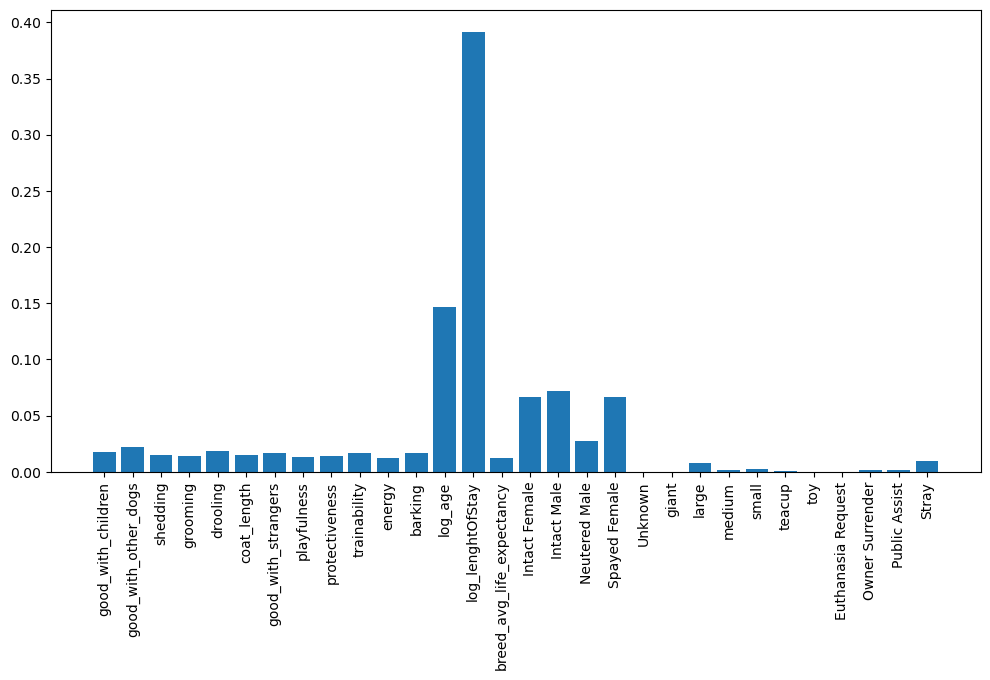

In [69]:
plt.figure(figsize=(12,6))
plt.bar(columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

##### Comment
Of all the parameters, it seems that the dog's size is the least relevant when using the random forest classifier. This was also true with the Decision Tree Classifier. To improve results, I am performing model selection with cross-validation. 

In [46]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini','entropy'],
    'max_depth': [4,5,6,7],
    'min_samples_split': [5, 10, 20, 25], 
    'min_samples_leaf': [5, 10, 20, 25] 
}

forest = RandomForestClassifier()

forestCV = GridSearchCV(forest, param_grid=param_grid, cv=10, refit=True, scoring='accuracy')

forestCV.fit(X_train_o, y_train_o)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7],
                         'min_samples_leaf': [5, 10, 20, 25],
                         'min_samples_split': [5, 10, 20, 25],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [47]:
forestCV.best_estimator_

RandomForestClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=10,
                       n_estimators=50)

In [48]:
forestCV.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 50}

##### Comment
Based on the results of the cross validation, I am choosing the above parameters for my random forest classifier.
First of all, I am going to try this again on training and validation set to see which features were most important for the model.

In [70]:
rf=RandomForestClassifier(n_estimators=50, max_depth=7, criterion='gini',
                             min_samples_split=10, min_samples_leaf=10)
rf.fit(X_train_o,y_train_o)
y_pred=rf.predict(X_test)

print(classification_report(y_test, y_pred, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.8563    0.5581    0.6757       267
           Dead     1.0000    0.0966    0.1761       145
Return to Owner     0.0000    0.0000    0.0000        46
       Transfer     0.7305    0.9752    0.8353       806

       accuracy                         0.7508      1264
      macro avg     0.6467    0.4074    0.4218      1264
   weighted avg     0.7614    0.7508    0.6956      1264



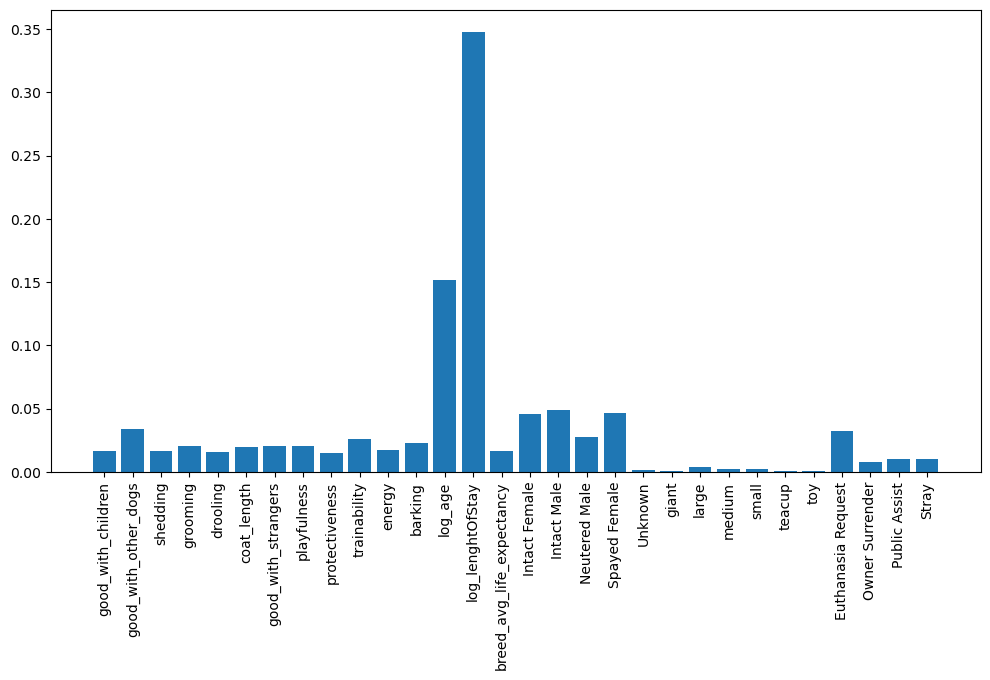

In [71]:
columns=temp.columns
plt.figure(figsize=(12,6))
plt.bar(columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

##### Comment
Although this is so far the best classifier amongst the tested one, it is not able to predict well the 'Returned to owner' category. Age and length of stay are still the most important features in classification.

In [72]:
abc=AdaBoostClassifier(algorithm='SAMME',n_estimators=100)

abc.fit(X_train,y_train)
y_v=abc.predict(X_val)

print(classification_report(y_val, y_v, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.6497    0.5455    0.5930       187
           Dead     0.7097    0.2157    0.3308       102
Return to Owner     0.0000    0.0000    0.0000        31
       Transfer     0.7363    0.9044    0.8118       565

       accuracy                         0.7175       885
      macro avg     0.5239    0.4164    0.4339       885
   weighted avg     0.6891    0.7175    0.6817       885



##### Comment
A first try with the AdaBoost classifier gives an accuracy of approximately 72% on the validation set. All outcomes are predicted in some measure.
Trying model selection with cross validation to see how resuts can be improved.

In [73]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300]
}

ada = AdaBoostClassifier(algorithm='SAMME')

adaCV = GridSearchCV(ada, param_grid=param_grid, cv=10, refit=True, scoring='accuracy')

adaCV.fit(X_train_o, y_train_o)

GridSearchCV(cv=10, estimator=AdaBoostClassifier(algorithm='SAMME'),
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='accuracy')

In [74]:
adaCV.best_estimator_

AdaBoostClassifier(algorithm='SAMME', n_estimators=200)

In [75]:
adaCV.best_score_

0.7186994119681771

In [76]:
abc=AdaBoostClassifier(algorithm='SAMME',n_estimators=200)

abc.fit(X_train_o,y_train_o)
y_pred=abc.predict(X_test)

print(classification_report(y_test, y_pred, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.7466    0.6180    0.6762       267
           Dead     0.5469    0.2414    0.3349       145
Return to Owner     0.8125    0.2826    0.4194        46
       Transfer     0.7601    0.9082    0.8276       806

       accuracy                         0.7476      1264
      macro avg     0.7165    0.5125    0.5645      1264
   weighted avg     0.7347    0.7476    0.7242      1264



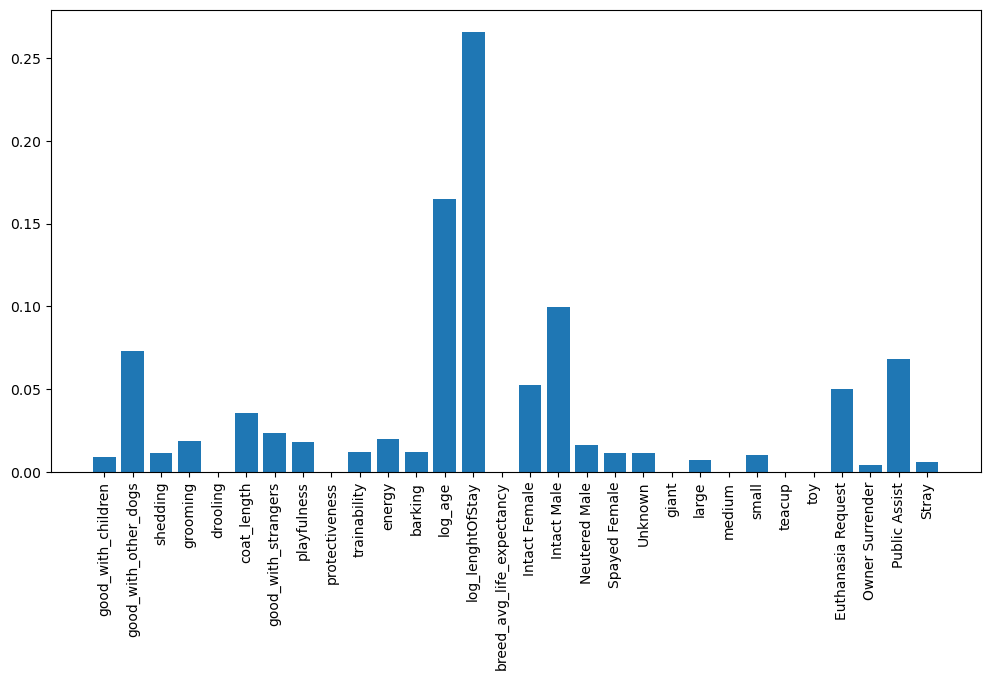

In [77]:
columns=temp.columns
plt.figure(figsize=(12,6))
plt.bar(columns, abc.feature_importances_)
plt.xticks(rotation=90)
plt.show()

##### Comment
After model selection, the chosen model returned an accuracy of 75% overall. This is similar to the result obtained with the random forest classifier, but it has the ability to classify all outcomes. 

In [78]:
bag= BaggingClassifier(n_estimators=100)

bag.fit(X_train,y_train)
y_v=bag.predict(X_val)

print(classification_report(y_val, y_v, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.6962    0.5882    0.6377       187
           Dead     0.5806    0.1765    0.2707       102
Return to Owner     0.4286    0.0968    0.1579        31
       Transfer     0.7417    0.9044    0.8150       565

       accuracy                         0.7254       885
      macro avg     0.6118    0.4415    0.4703       885
   weighted avg     0.7025    0.7254    0.6918       885



##### Comment
A first try with the bagging classifier gives an accuracy of 73% on the validation set, and all outcomes are predicted. Trying model selection on the whole training dataset.

In [79]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300], 
    'max_features': [5, 10, 15, 20, 25,30] 
}

bc = BaggingClassifier()

bcCV = GridSearchCV(bc, param_grid=param_grid, cv=10, refit=True, scoring='accuracy')

bcCV.fit(X_train_o, y_train_o)

GridSearchCV(cv=10, estimator=BaggingClassifier(),
             param_grid={'max_features': [5, 10, 15, 20, 25, 30],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='accuracy')

In [80]:
bcCV.best_estimator_

BaggingClassifier(max_features=30, n_estimators=200)

In [81]:
bcCV.best_score_

0.746182405165456

In [83]:
bag= BaggingClassifier(n_estimators=200, max_features=30)

bag.fit(X_train_o,y_train_o)
y_pred=bag.predict(X_test)

print(classification_report(y_test, y_pred, digits=4,zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.8058    0.6217    0.7019       267
           Dead     0.7308    0.2621    0.3858       145
Return to Owner     0.5455    0.2609    0.3529        46
       Transfer     0.7673    0.9367    0.8436       806

       accuracy                         0.7682      1264
      macro avg     0.7123    0.5203    0.5711      1264
   weighted avg     0.7632    0.7682    0.7433      1264



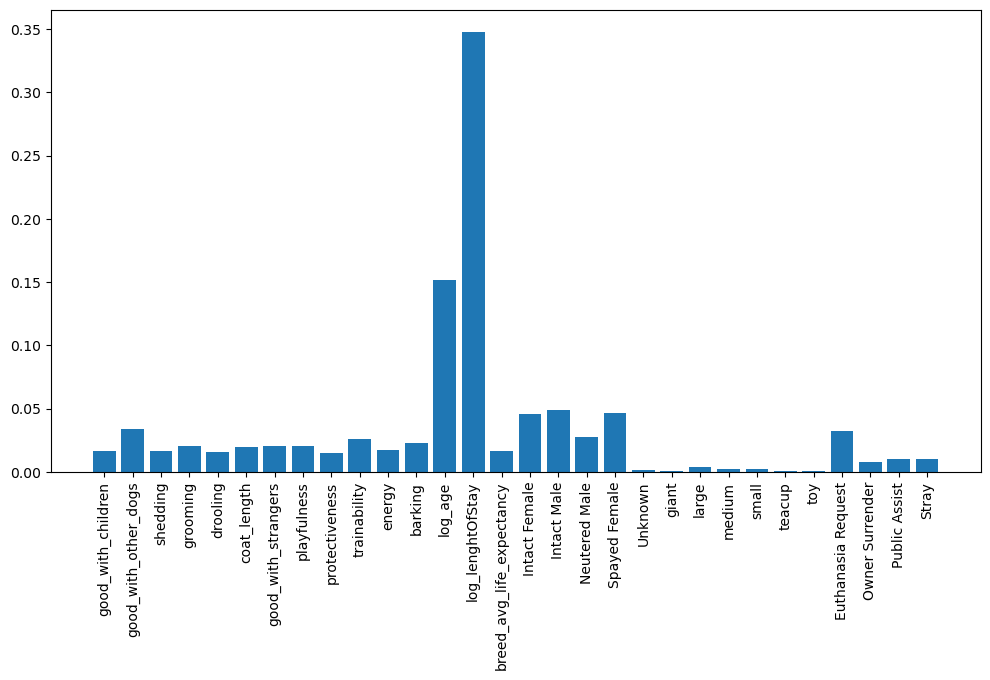

In [84]:
plt.figure(figsize=(12,6))
plt.bar(columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

## SVM
- find the best parameters
- evaluate the model

In [85]:
from sklearn.svm import LinearSVC, SVC

In [86]:
standard=StandardScaler()
X_tr_o=standard.fit_transform(X_train_o)
X_tr=standard.fit_transform(X_train)
X_v=standard.transform(X_val)
X_ts=standard.transform(X_test)

In [87]:
lsvm=LinearSVC(C=1.0)

lsvm.fit(X_tr,y_train)
y_v=lsvm.predict(X_v)

print(classification_report(y_val, y_v, digits=4, zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.7415    0.5829    0.6527       187
           Dead     0.8462    0.1078    0.1913       102
Return to Owner     0.0000    0.0000    0.0000        31
       Transfer     0.7297    0.9363    0.8202       565

       accuracy                         0.7333       885
      macro avg     0.5793    0.4068    0.4160       885
   weighted avg     0.7200    0.7333    0.6836       885



In [88]:
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1.0] 
}

sv = LinearSVC()

svCV = GridSearchCV(sv, param_grid=param_grid, cv=10, refit=True, scoring='accuracy')

svCV.fit(X_tr_o, y_train_o)

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]},
             scoring='accuracy')

In [89]:
svCV.best_estimator_

LinearSVC(C=0.5)

In [91]:
lsvm=LinearSVC(C=0.5)

lsvm.fit(X_tr_o,y_train_o)
y_pred=lsvm.predict(X_ts)

print(classification_report(y_test, y_pred, digits=4, zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.7941    0.6067    0.6879       267
           Dead     0.8000    0.1103    0.1939       145
Return to Owner     0.0000    0.0000    0.0000        46
       Transfer     0.7346    0.9479    0.8277       806

       accuracy                         0.7453      1264
      macro avg     0.5822    0.4162    0.4274      1264
   weighted avg     0.7280    0.7453    0.6954      1264



##### Comment
Linear SVM after model selection returns an accuracy of approximately 75% but is unable to predict the 'return to owner' outcome.

In [93]:
nlsvm=SVC(C=1.0)

nlsvm.fit(X_tr,y_train)
y_v=lsvm.predict(X_v)

print(classification_report(y_val, y_v, digits=4, zero_division=0))

                 precision    recall  f1-score   support

       Adoption     0.7533    0.6043    0.6706       187
           Dead     0.8462    0.1078    0.1913       102
Return to Owner     0.0000    0.0000    0.0000        31
       Transfer     0.7341    0.9381    0.8236       565

       accuracy                         0.7390       885
      macro avg     0.5834    0.4125    0.4214       885
   weighted avg     0.7253    0.7390    0.6896       885



In [94]:
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1.0] 
}

nlsv = SVC()

nlsvCV = GridSearchCV(nlsv, param_grid=param_grid, cv=10, refit=True, scoring='accuracy')

nlsvCV.fit(X_tr_o, y_train_o)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]},
             scoring='accuracy')

In [96]:
nlsvCV.best_params_

{'C': 1.0}

## Wrap Up
- comment on your findings:
    - which model performed best?
    - which are the most important features?
    - which are the most difficult classes to predict?
- can you say something about the outcome of a dog?

##### Comment
The best performing models on this dataset were the AdaBoost and Bagging classifiers, which were both able to predict all outcomes.
The most difficult class to predict was 'returned to owner', due to the fact that it had the least samples available. On this class, all other classifiers failed.

Looking at the features used by the different classifiers, we can see that the size of the dog is consistently the least important feature. It is possible that removing the class entirely might improve the performance of all classifiers.

To conclude, we can say that correctly predicting the outcome of a dog can be achieved with an accuracy of approximately 75% overall; however, the accuracy is higher when looking at the ability to predict the outcome 'transfer' compared to all other classes. This can be explained with the fact that this particular outcome made up approx. 50% of the dataset.